In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
tickers = ["AWK","GOOG","SAP","TSLA","VFIAX"]
start = datetime.datetime(2014, 8, 31)
end = datetime.datetime(2019, 8, 31)

df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

In [3]:
input=["AWK","GOOG","SAP","TSLA","VFIAX"]
data=pd.DataFrame()
data["Date"]=pd.read_csv(input[0]+".csv", engine='python',usecols=['Date'])

In [4]:
input=["AWK","GOOG","SAP","TSLA","VFIAX"]
data=pd.DataFrame()
data["Date"]=pd.read_csv(input[0]+".csv", engine='python',usecols=['Date'])
for i in input:
    company=i
    df = pd.read_csv(company+".csv", engine='python')
    data[company]=df["Adj Close"]

In [5]:
table=data
table=data.set_index('Date')

Text(0,0.5,'price in $')

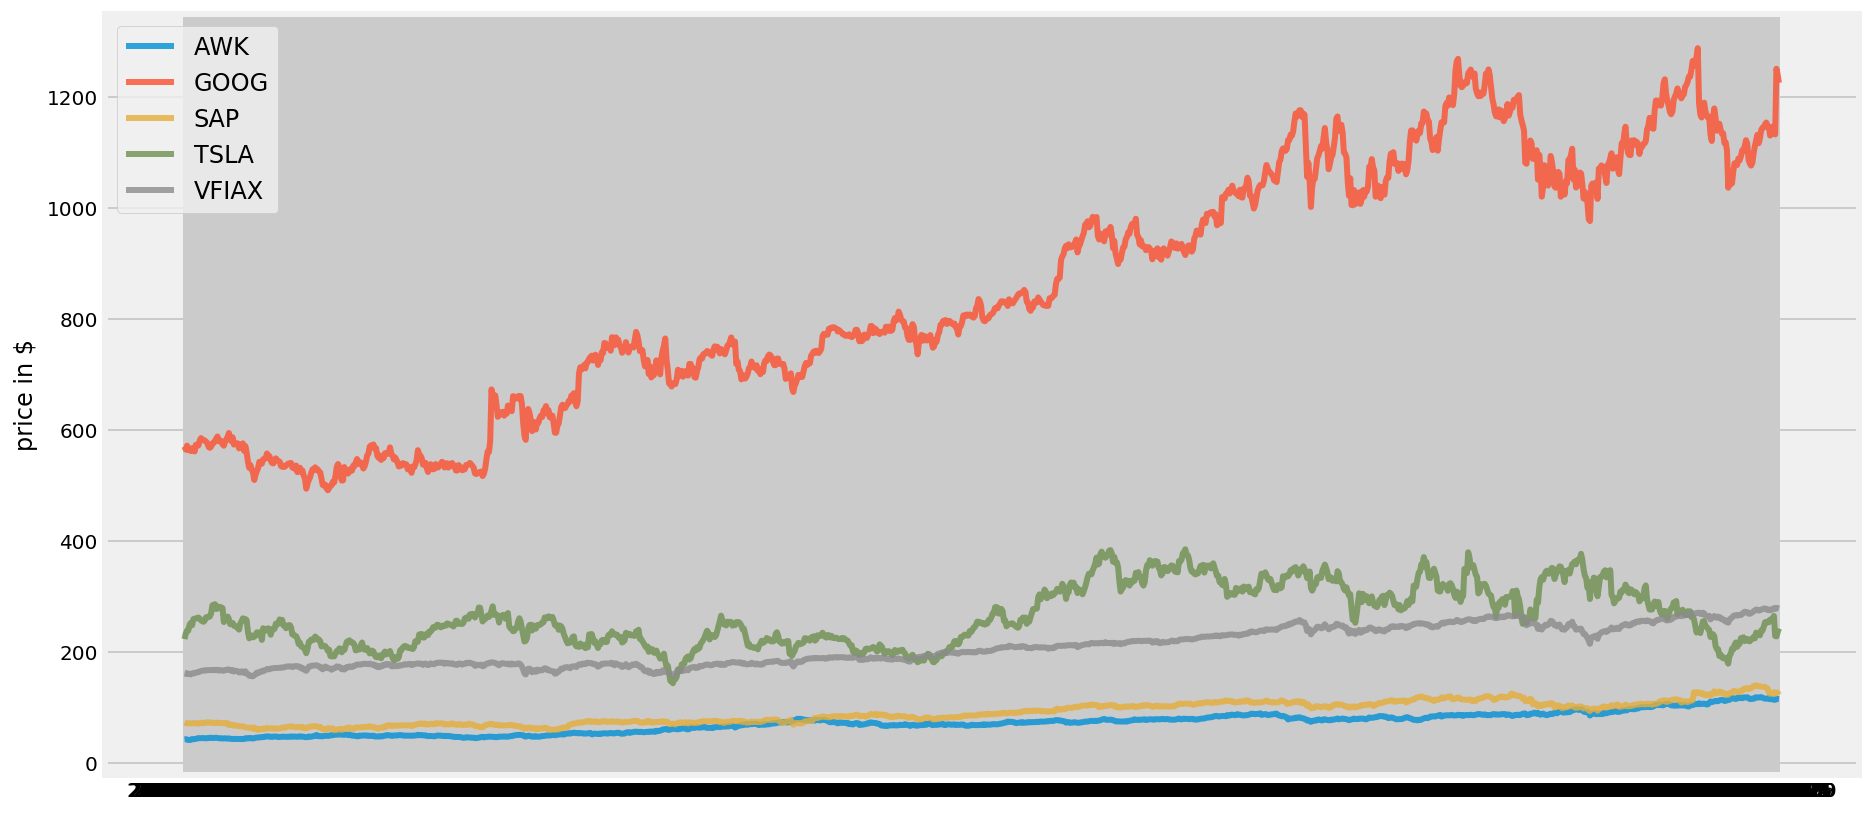

In [6]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

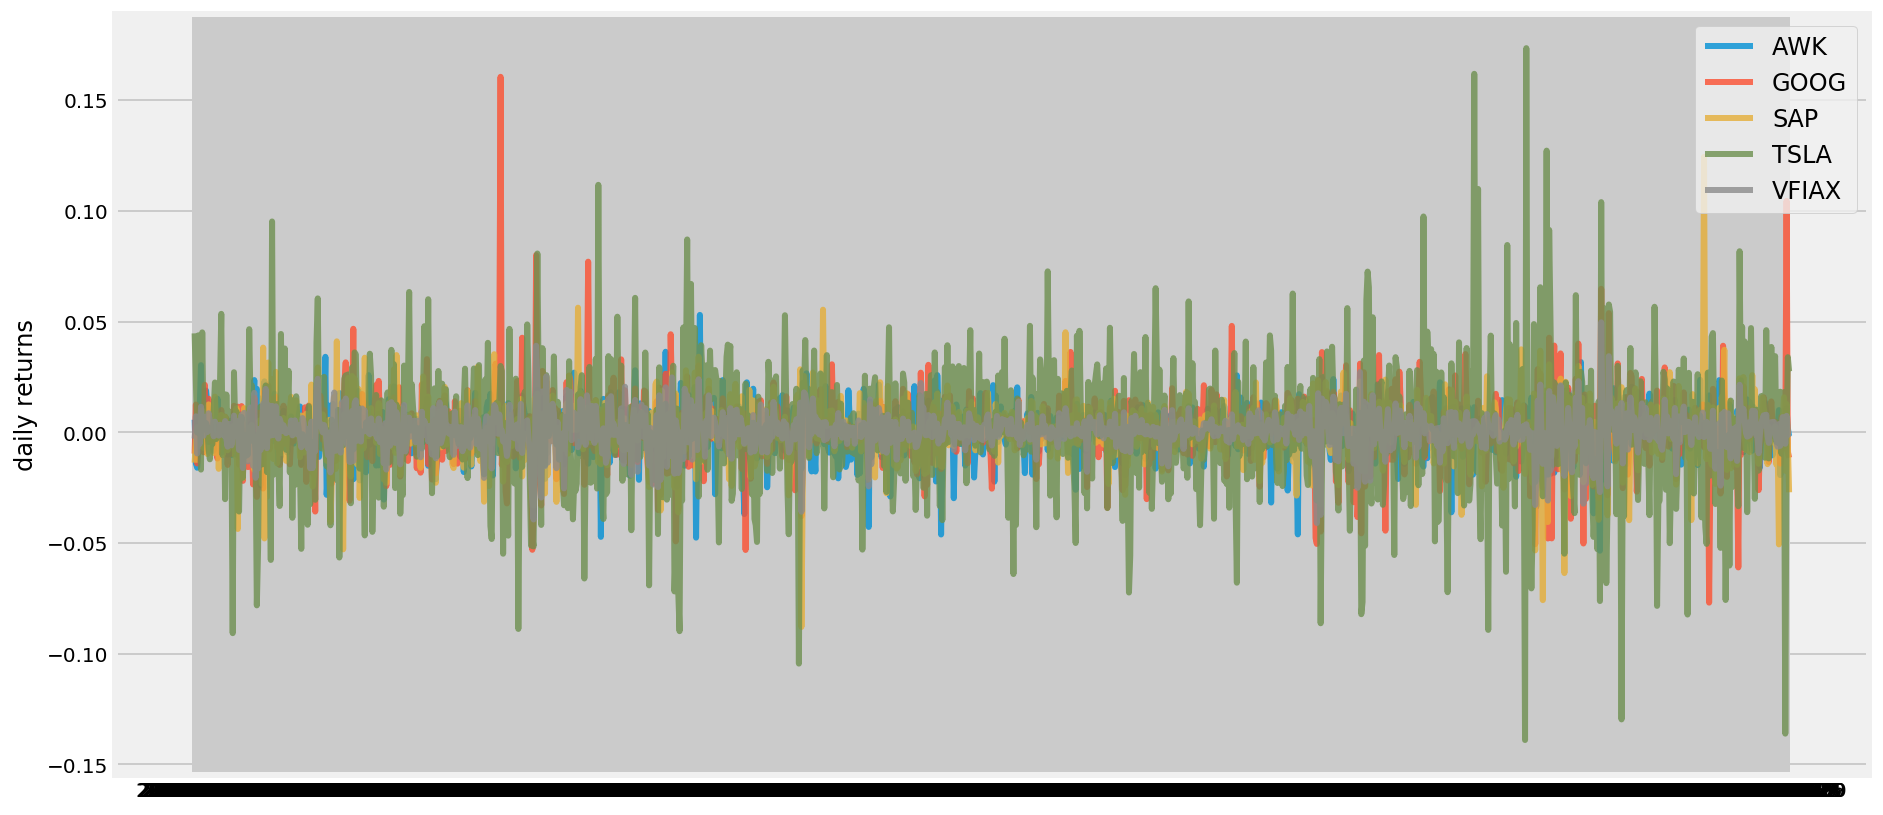

In [7]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [13]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [17]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

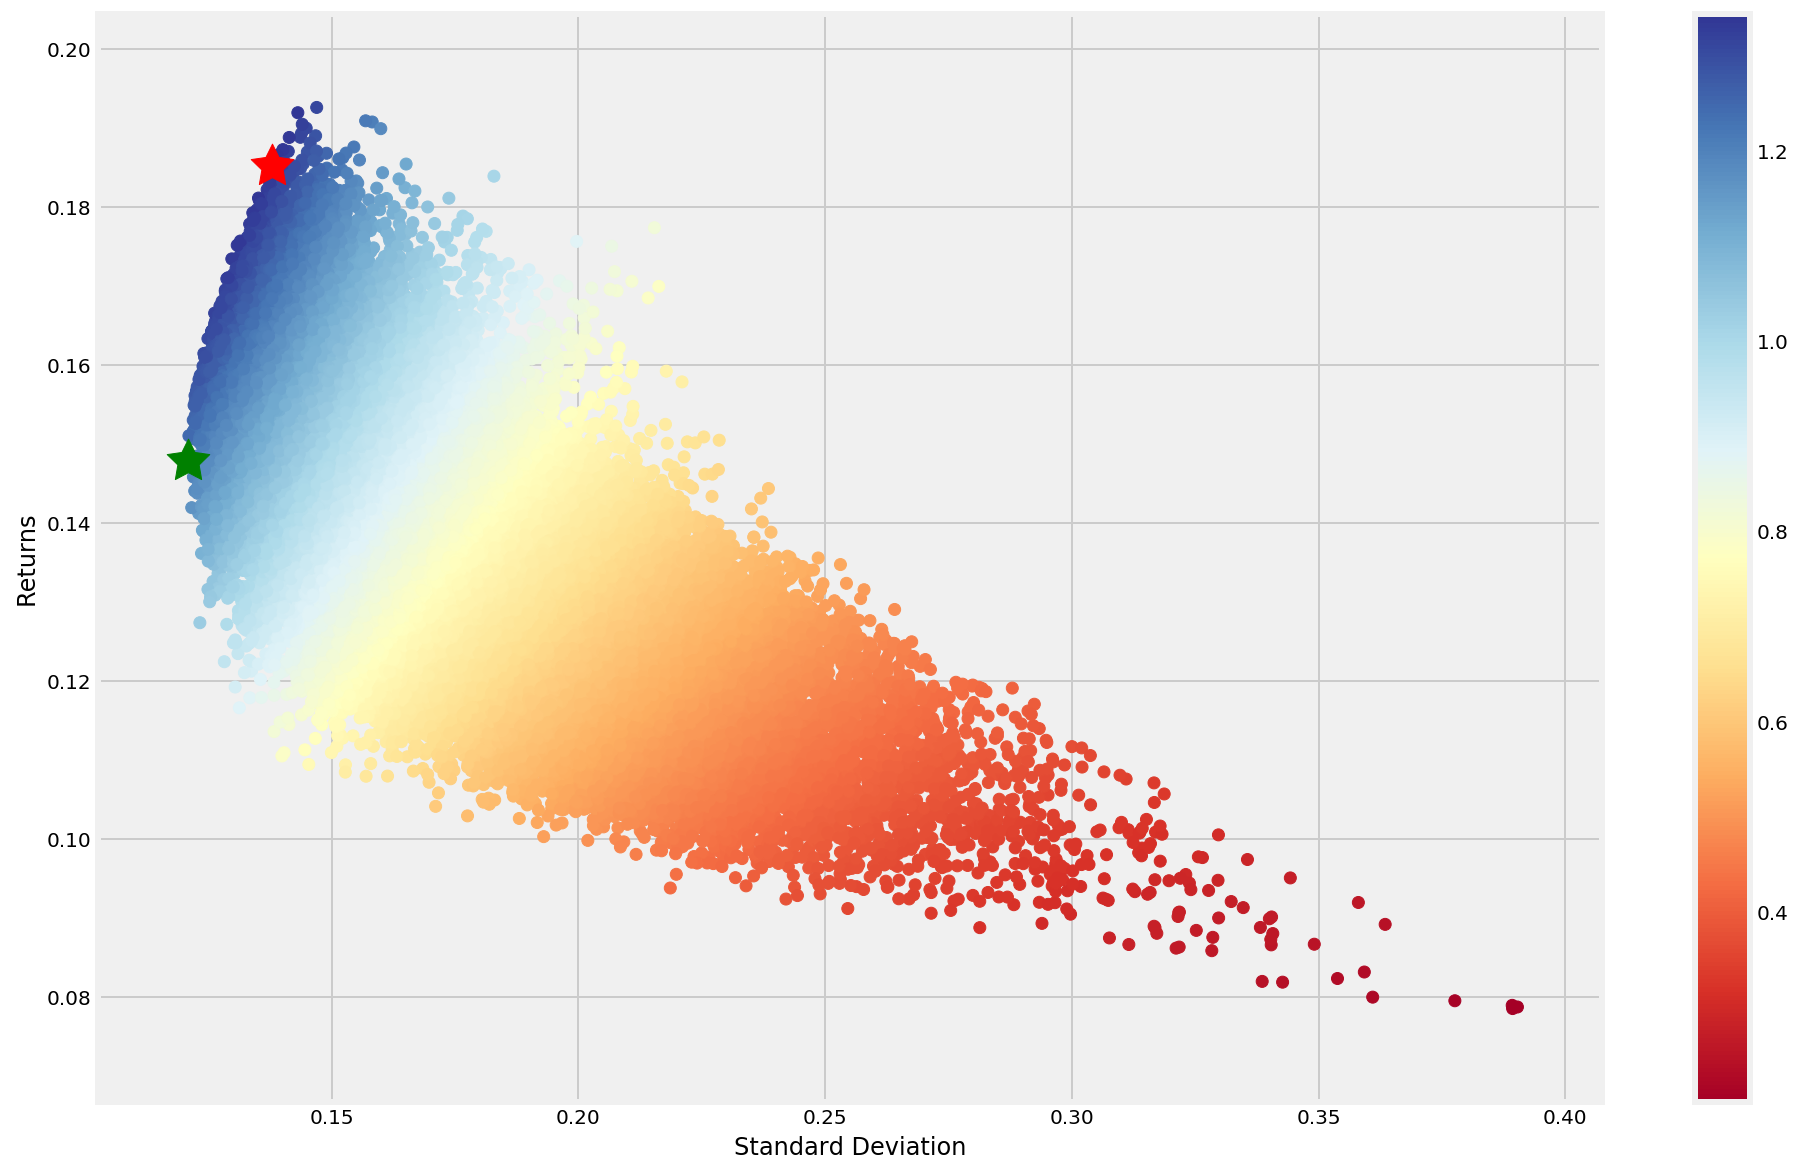

In [18]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

In [19]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,AWK,GOOG,SAP,TSLA,VFIAX
86379,0.185189,0.137841,1.343495,0.678225,0.142191,0.03301,0.003693,0.14288


In [20]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,AWK,GOOG,SAP,TSLA,VFIAX
95436,0.147822,0.120829,1.223391,0.392604,0.009397,0.012022,0.013198,0.57278


In [21]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [22]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,AWK,GOOG,SAP,TSLA,VFIAX
0,0.66,0.2,0.09,0.0,0.05


In [24]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(mean_returns, cov)

In [25]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

,AWK,GOOG,SAP,TSLA,VFIAX
0,0.34,0.0,0.03,0.0,0.63


In [26]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var


def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

In [27]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05

results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

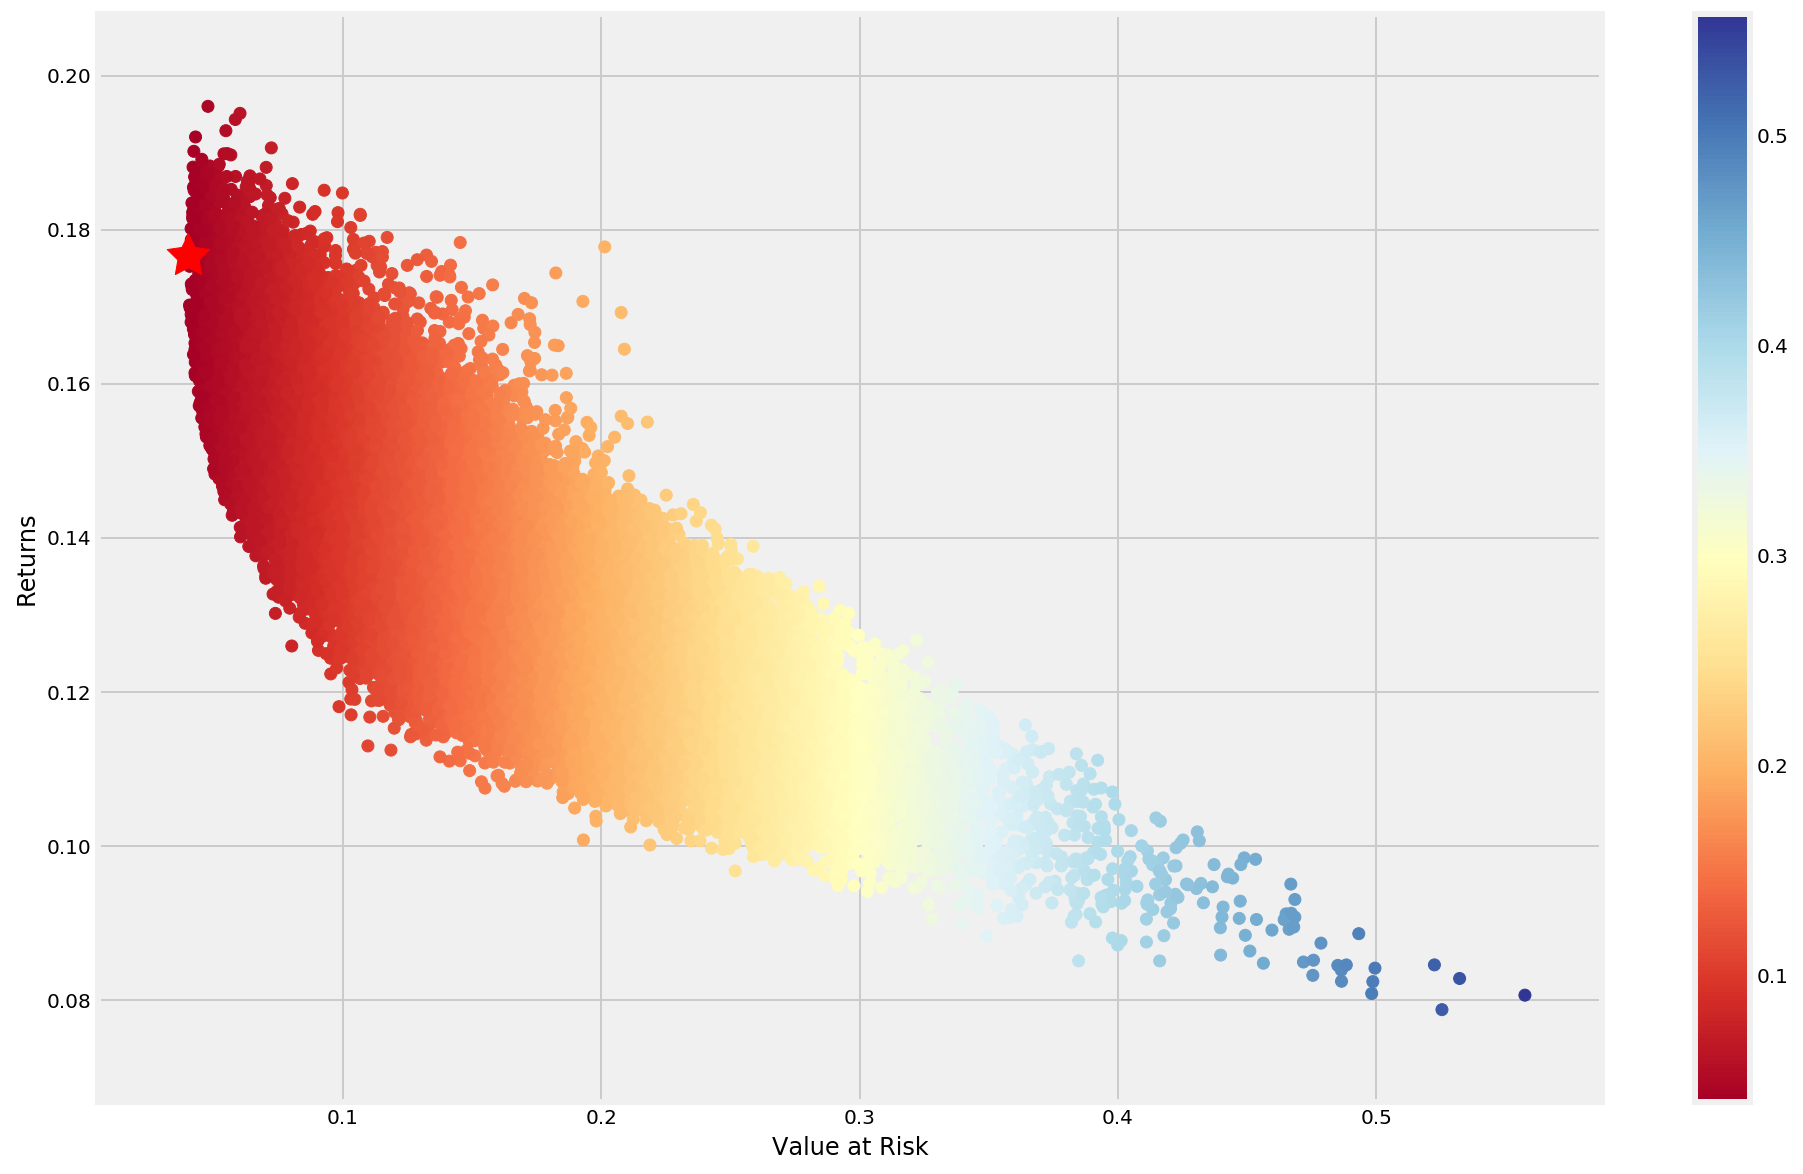

In [28]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [29]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,AWK,GOOG,SAP,TSLA,VFIAX
41847,0.176644,0.131675,0.039943,0.569966,0.162,0.041878,0.000603,0.225553


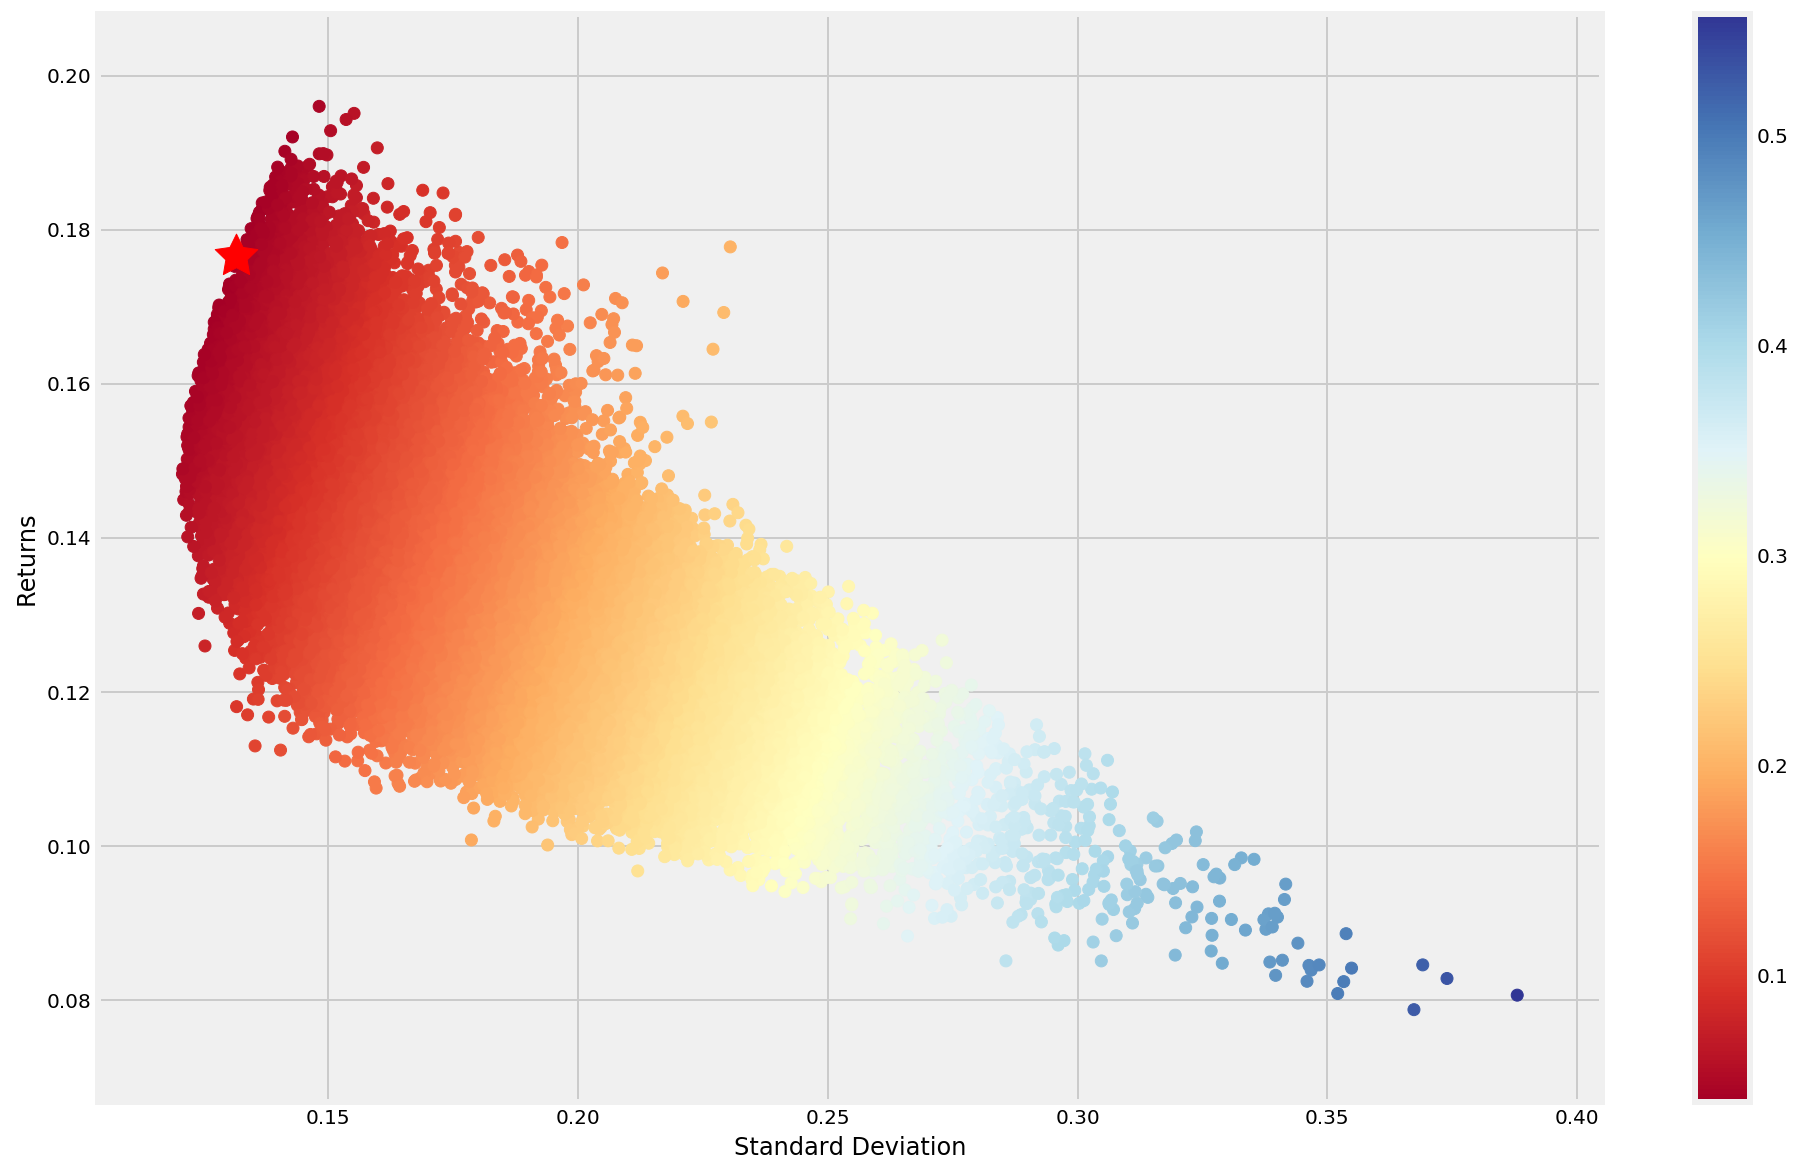

In [30]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [31]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [32]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,AWK,GOOG,SAP,TSLA,VFIAX
0,0.59,0.14,0.08,0.0,0.19
